In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt

### Note: code also uploaded to github. https://github.com/Haiyun314/Image_processing/tree/main
Python3 --version = 3.10.8

numpy.__version__ = '1.23.2' 

matplotlib.__version__ = '3.6.3'

## Differential operators

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def test_imageinfo(image:np.ndarray) -> None:
    print(image.shape)
    print(np.max(image), np.min(image))

class Diff:
    '''
    boundary condition: periodic
    discretize: backward differences
    '''
    def __init__(self, image: np.ndarray) -> None:
        self.image = image

    def grad(self, grad_image: np.ndarray = None) -> np.ndarray:
        image = grad_image if grad_image is not None else self.image

        image_hori_shift = np.concatenate((image[..., 1:], image[..., :1]), axis=-1)
        image_vert_shift = np.concatenate((image[1:, ...], image[:1, ...]), axis=0)

        grad_hori = image - image_hori_shift
        grad_vert = image - image_vert_shift

        result = np.stack((grad_hori, grad_vert), axis=0)

        try:
            result[0] == grad_hori
        except IndexError:
            raise "index doesn't match"
        
        return np.stack((grad_hori, grad_vert), axis=0)
    
    def div(self) -> np.ndarray:
        h_v_grad = self.grad()
        return h_v_grad[0, ...] + h_v_grad[1, ...]
    
    def lapl(self) -> np.ndarray:
        first_grad = self.grad()
        twice_hori_grad = self.grad(first_grad[0, ...])[0, ...]
        twice_vert_grad = self.grad(first_grad[1, ...])[1, ...]
        return twice_hori_grad + twice_vert_grad


## Gradient descent 

In [11]:
def tykhonov_gradient(noise_image, lam, iterations):
    u_t = noise_image
    max_ite = iterations

    while iterations> 1:
        diff = Diff(u_t)
        iterations -= 1
        J_d = noise_image - u_t - lam * diff.lapl()
        u_t = u_t - 0.001 * J_d
        if max_ite % iterations == 0:
            print(max_ite % iterations)
            print(f'processing {(max_ite - iterations)/max_ite*100 :.2f}%')
    return u_t


## Fourier space

In [9]:
def tykhonov_fourier_denoise(image, lam):
    shape = image.shape
    f = np.fft.fft2(image)
    
    #frequency grids
    i = np.linspace(0, 1, shape[0])
    j = np.linspace(0, 1, shape[1])
    I, J = np.meshgrid(i, j, indexing='ij')

    #the denominator 
    denom = 1 + 8 * lam * (np.square(np.sin(np.pi * I)) + np.square(np.sin(np.pi * J)))
    
    u = f / denom
    
    denoised_image = np.fft.ifft2(u)
    denoised_image = np.real(denoised_image)
    
    return denoised_image


## Testing

(256, 256)
1.0 0.0
0
processing 50.00%
0
processing 75.00%
0
processing 80.00%
0
processing 87.50%
0
processing 90.00%
0
processing 95.00%
0
processing 96.00%
0
processing 97.50%
0
processing 98.00%
0
processing 99.00%
0
processing 99.20%
0
processing 99.50%
0
processing 99.60%
0
processing 99.80%
0
processing 99.90%


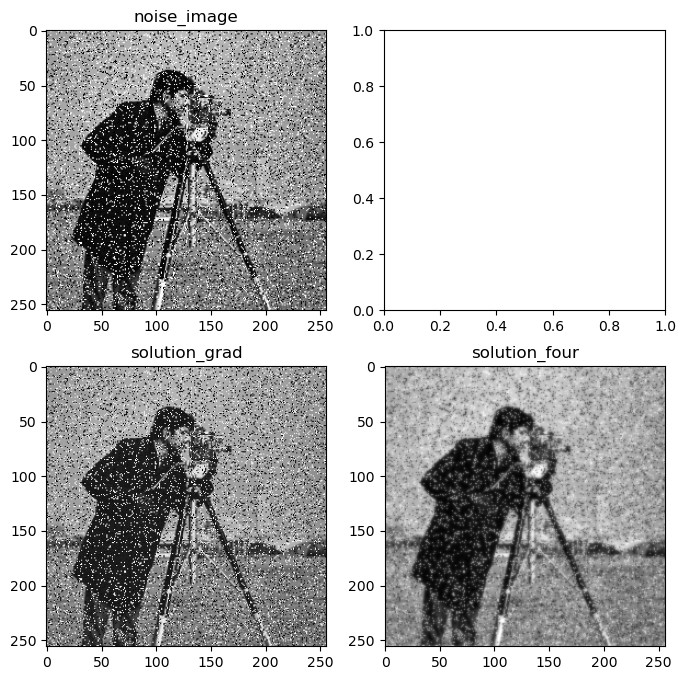

In [10]:
if __name__ == '__main__':
    noise_image = plt.imread('images/cameraman_sp.png')
    test_imageinfo(noise_image)

    solution_grad = tykhonov_gradient(noise_image, 0.01, 1000)
    solution_four = tykhonov_fourier_denoise(noise_image,0.5)

    _, ax = plt.subplots(2, 2, figsize = (8, 8))
    ax[0, 0].imshow(noise_image, cmap= 'gray')
    ax[0, 0].set_title('noise_image')
    ax[1, 0].imshow(solution_grad, cmap= 'gray')
    ax[1, 0].set_title('solution_grad')
    ax[1, 1].imshow(solution_four, cmap= 'gray')
    ax[1, 1].set_title('solution_four')

    plt.show()